In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D,Dense, GlobalAveragePooling1D, Embedding, MultiHeadAttention
from tensorflow.keras.layers import MaxPool1D, Dropout, LayerNormalization, MaxPooling1D, Input
from tensorflow.keras.models import Sequential, Model

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-04-04 00:31:16.601795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 00:31:16.606363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 00:31:16.606811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [19]:
weight_address = 'weights/'
results_address = 'results/'
NUM_CLASSES = 6

### The networks

#### Transformer

In [4]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.embed_dim = embed_dim
        self.token_emb = Embedding(input_dim= vocab_size, output_dim= embed_dim)
        self.maxlen = maxlen

    def get_angles(self, pos, i, embd_dim):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embd_dim))
        return pos * angle_rates

    def positional_encoding(self, max_pos_enc, embd_dim):
        angle_rads = self.get_angles(np.arange(max_pos_enc)[:, np.newaxis],
                                np.arange(embd_dim)[np.newaxis, :],
                                embd_dim)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        positions = self.positional_encoding(max_pos_enc= self.maxlen, embd_dim= self.embed_dim)
        x = self.token_emb(x)
        return x + positions

In [5]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads= num_heads, key_dim= embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Transformer and CNN

In [6]:
@tf.autograph.experimental.do_not_convert # added to silence a warning related to TF
def create_model_cnn_transformer(maxlen = 30121, vocab_size = 259,
                                embed_dim = 50, num_heads = 2, 
                                ff_dim = 16, dout = 0.1,
                                filters = 64, kernel_size = 3, 
                                pool_window = 2, extra_dense_nodes = 20, pool = 'maxpool',
                                summary = True):
    '''
    embed_dim - Embedding size for each token
    num_heads - Number of attention heads
    ff_dim - Hidden layer size in feed forward network inside transformer
    pool - can be "maxpool" for local maxpooling or "globalAvg" for global average pooling
    '''
    # input
    inputs = Input(shape=(maxlen,))
    # embeddding
    embedding_layer = TokenAndPositionEmbedding(inputs.shape[1], vocab_size, embed_dim)
    x = embedding_layer(inputs)
    # convolution
    x = Conv1D(filters= filters, kernel_size= kernel_size)(x)
    if pool == 'maxpool':
        x = MaxPooling1D(pool_size= pool_window)(x)
    else:
        print('the feature not working yet')

    print(x.shape)
    # transformer
    transformer_block = TransformerBlock(filters, num_heads, ff_dim)
    # print('transformer_block input shape:', x.shape)
    x = transformer_block(x)
    # extra dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dout)(x)
    if extra_dense_nodes!= 0:
        x = Dense(extra_dense_nodes, activation= "relu")(x)
        x = Dropout(dout)(x)
    # output
    outputs = Dense(NUM_CLASSES, activation= "softmax")(x)

    model= Model(inputs=inputs, outputs= outputs)
    if summary:
        model.summary()
    
    return model

### CNN

In [7]:
def create_CNN_model(layers = 2, filters = [32, 64, 128], kernel_size= 3,
                      embed_dim = 50, vocab_size = 259, summary= False):

    model = Sequential()
    model.add(Embedding(vocab_size+1, embed_dim))#, input_length = X_train_padded.shape[1]))
    
    for i in range(layers):
        model.add(Conv1D(filters = filters[i], kernel_size = kernel_size, activation='relu'))
        model.add(MaxPool1D(pool_size = 2, strides=2))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(NUM_CLASSES, activation= 'softmax'))
    if summary:
        model.summary()
    return model

### Kmer method

#### Loading the saved data

In [8]:
with open('X_train_k3.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('Y_train_k3.pkl', 'rb') as f:
    Y_train = pickle.load(f)
    
X_train.shape, Y_train.shape

((1500, 30121), (1500,))

In [9]:
with open('X_test_list_k3.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('Y_test_list_k3.pkl', 'rb') as f:
    Y_test = pickle.load(f)

X_test[0].shape, Y_test[0].shape    

((1090, 30121), (1090,))

#### Training helpers

In [10]:
model_names = ['transformer_cnn_k3_32f_4pool',
            'transformer_cnn_k3_64f_4pool',
            'transformer_cnn_k3_128f_4pool',
            'cnn_k3_2layers']

In [11]:
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose= 1
    )

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=5,
    mode="auto",
    restore_best_weights=True,
)

adam_opt = tf.keras.optimizers.Adam(learning_rate= 3e-3)

In [12]:
def evaluate_model(model, model_name):
    test_indicies = [2,3,4,5,1]

    model.load_weights(weight_address+model_name) # loads the best weight before evaluating
    for i in range(5):
        print('Test set {} F1 score:'.format(test_indicies[i]))
        preds = np.argmax(model.predict(X_test[i], batch_size=4), axis = 1)
        score = f1_score(Y_test[i], preds, average = 'weighted')
        print(score)
        with open(results_address+model_name+'_test_results.txt','a') as f:
            f.write('Test set '+str(test_indicies[i])+' F1 score:')
            f.write('\n'+str(score))
            f.write('\n===\n')

In [13]:
def plot_history(history, model_name):
    print('Highest train acc: {:.3f} epoch: {}\nHighest val acc: {:.3f} epoch: {}'\
        .format(max(history.history['accuracy']), 1+np.argmax(np.array(history.history['accuracy'])),
                max(history.history['val_accuracy']), 1+np.argmax(np.array(history.history['val_accuracy']))))

    plt.title('Training history of '+ model_name)
    plt.plot(history.history['accuracy'],'ro-')
    plt.plot(history.history['val_accuracy'],'bx-')
    plt.legend(['accuracy','val_accuracy'])
    plt.savefig(results_address+model_name+'.png')
    plt.show()

In [14]:
def make_checkpointer(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
    weight_address + model_name, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True)

In [15]:
metrics = ['accuracy']

#### Training

data with pool size smaller than 4 does not fit in my GPU

In [16]:
eps = 20

transformer_cnn_k3_32f_4pool
Epoch 1/20
375/375 [==============================] - 92s 245ms/step - loss: 0.8892 - accuracy: 0.5807 - val_loss: 0.6242 - val_accuracy: 0.7248 - lr: 0.0030
Epoch 2/20
375/375 [==============================] - 91s 244ms/step - loss: 0.5927 - accuracy: 0.6727 - val_loss: 0.6545 - val_accuracy: 0.8028 - lr: 0.0030
Epoch 3/20
375/375 [==============================] - 92s 244ms/step - loss: 0.4341 - accuracy: 0.7720 - val_loss: 0.4142 - val_accuracy: 0.7945 - lr: 0.0030
Epoch 4/20
375/375 [==============================] - 92s 245ms/step - loss: 0.3417 - accuracy: 0.8060 - val_loss: 0.4278 - val_accuracy: 0.8670 - lr: 0.0030
Epoch 5/20
375/375 [==============================] - 92s 245ms/step - loss: 0.2987 - accuracy: 0.8467 - val_loss: 0.4101 - val_accuracy: 0.9202 - lr: 0.0030
Epoch 6/20
375/375 [==============================] - 92s 245ms/step - loss: 0.2939 - accuracy: 0.8827 - val_loss: 0.8633 - val_accuracy: 0.7688 - lr: 0.0030
Epoch 7/20
375/375 [===

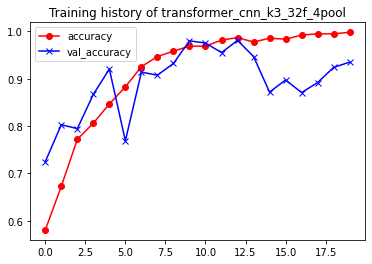

Test set 2 F1 score:
0.9751986427186882
Test set 3 F1 score:
0.9902582521030951
Test set 4 F1 score:
0.9945917627482705
Test set 5 F1 score:
0.9885778765600799
Test set 1 F1 score:
0.978563568443893


In [43]:
model_name = model_names[0]
print(model_name)

check_point = make_checkpointer(model_name)
model = create_model_cnn_transformer(filters=32, pool_window=4)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics= metrics)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)


transformer_cnn_k3_64f_4pool
Epoch 1/20
375/375 [==============================] - 102s 270ms/step - loss: 1.2368 - accuracy: 0.4327 - val_loss: 0.8511 - val_accuracy: 0.7248 - lr: 0.0030
Epoch 2/20
375/375 [==============================] - 101s 268ms/step - loss: 0.8395 - accuracy: 0.6087 - val_loss: 0.7092 - val_accuracy: 0.7239 - lr: 0.0030
Epoch 3/20
375/375 [==============================] - 101s 268ms/step - loss: 0.7446 - accuracy: 0.6153 - val_loss: 0.6833 - val_accuracy: 0.7339 - lr: 0.0030
Epoch 4/20
375/375 [==============================] - 101s 268ms/step - loss: 0.6689 - accuracy: 0.6427 - val_loss: 0.7860 - val_accuracy: 0.6303 - lr: 0.0030
Epoch 5/20
375/375 [==============================] - 101s 269ms/step - loss: 0.6513 - accuracy: 0.6560 - val_loss: 0.8346 - val_accuracy: 0.7239 - lr: 0.0030
Epoch 6/20
375/375 [==============================] - 101s 269ms/step - loss: 0.6492 - accuracy: 0.6467 - val_loss: 0.8134 - val_accuracy: 0.7229 - lr: 0.0030
Epoch 7/20
375/37

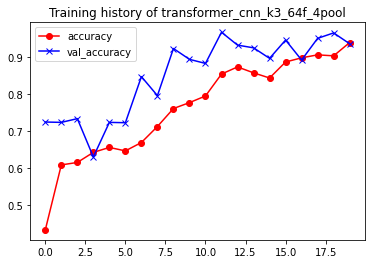

Test set 2 F1 score:
0.919684662084589
Test set 3 F1 score:
0.9405898605980496
Test set 4 F1 score:
0.9241338494641917
Test set 5 F1 score:
0.9419528254280054
Test set 1 F1 score:
0.8451301391772945


In [44]:
model_name = model_names[1]
print(model_name)
check_point = make_checkpointer(model_name)


model = create_model_cnn_transformer(filters=64, pool_window=4)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics=metrics)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

transformer_cnn_k3_128f_4pool
Epoch 1/15


2022-02-25 18:30:21.329434: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-02-25 18:30:21.521296: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


375/375 [==============================] - 121s 318ms/step - loss: 1.1746 - accuracy: 0.4440 - val_loss: 0.7004 - val_accuracy: 0.7624 - lr: 0.0030
Epoch 2/15
375/375 [==============================] - 119s 317ms/step - loss: 0.7045 - accuracy: 0.6333 - val_loss: 0.7285 - val_accuracy: 0.6303 - lr: 0.0030
Epoch 3/15
375/375 [==============================] - 119s 317ms/step - loss: 0.5857 - accuracy: 0.7127 - val_loss: 0.4790 - val_accuracy: 0.9000 - lr: 0.0030
Epoch 4/15
375/375 [==============================] - 119s 317ms/step - loss: 0.5529 - accuracy: 0.7413 - val_loss: 0.6846 - val_accuracy: 0.7358 - lr: 0.0030
Epoch 5/15
375/375 [==============================] - 119s 316ms/step - loss: 0.5095 - accuracy: 0.7580 - val_loss: 0.4853 - val_accuracy: 0.8936 - lr: 0.0030
Epoch 6/15
375/375 [==============================] - 119s 316ms/step - loss: 0.4469 - accuracy: 0.7787 - val_loss: 0.4921 - val_accuracy: 0.8055 - lr: 0.0030
Epoch 7/15
375/375 [==============================] - 119

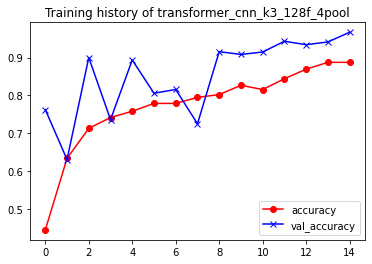

Test set 2 F1 score:
0.8666164338060677
Test set 3 F1 score:
0.9616046121776726
Test set 4 F1 score:
0.9693210152283223
Test set 5 F1 score:
0.9561821288042454
Test set 1 F1 score:
0.9519966347747435


In [19]:
model_name = model_names[2]
print(model_name)
check_point = make_checkpointer(model_name)


model = create_model_cnn_transformer(filters=128, pool_window=4)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=15,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

transformer_cnn_k3_128f_4pool
Epoch 1/5
375/375 [==============================] - 118s 312ms/step - loss: 0.4523 - accuracy: 0.7873 - val_loss: 0.4611 - val_accuracy: 0.9670 - lr: 7.5000e-04
Epoch 2/5
375/375 [==============================] - 117s 312ms/step - loss: 0.4212 - accuracy: 0.8213 - val_loss: 0.4531 - val_accuracy: 0.9578 - lr: 7.5000e-04
Epoch 3/5
375/375 [==============================] - 117s 312ms/step - loss: 0.4061 - accuracy: 0.8300 - val_loss: 0.4780 - val_accuracy: 0.9495 - lr: 7.5000e-04
Epoch 4/5
375/375 [==============================] - 117s 312ms/step - loss: 0.3816 - accuracy: 0.8327 - val_loss: 0.4956 - val_accuracy: 0.9147 - lr: 7.5000e-04
Epoch 5/5
375/375 [==============================] - 117s 312ms/step - loss: 0.3872 - accuracy: 0.8227 - val_loss: 0.5270 - val_accuracy: 0.9697 - lr: 7.5000e-04
Highest train acc: 0.833 epoch: 3
Highest val acc: 0.970 epoch: 4


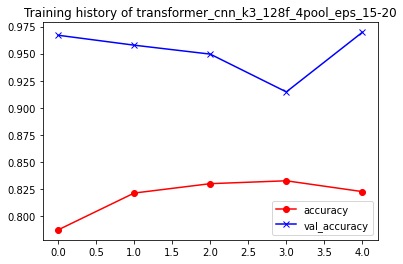

Test set 2 F1 score:
0.9589793937201796
Test set 3 F1 score:
0.9495300090664044
Test set 4 F1 score:
0.9569460290468971
Test set 5 F1 score:
0.960148959401414
Test set 1 F1 score:
0.9272750530959003


In [32]:
# training the model for 5 extra epochs
model_name = model_names[2]
print(model_name)

check_point = make_checkpointer(model_name)

model = create_model_cnn_transformer(cnn_filters=128, pool_window=4)
model.load_weights(weight_address+model_names[2]) 
model.compile(optimizer= tf.keras.optimizers.Adam(3e-3),
 loss= "sparse_categorical_crossentropy", metrics=['accuracy'])

K.set_value(model.optimizer.learning_rate, 7.5e-4)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=5,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history,  model_names[2]+'_eps_15-20')
evaluate_model(model, model_name)


cnn_k3_2layers
Epoch 1/20
375/375 [==============================] - 30s 78ms/step - loss: 0.6207 - accuracy: 0.7147 - val_loss: 2.3382 - val_accuracy: 0.9009 - lr: 0.0030
Epoch 2/20
375/375 [==============================] - 29s 78ms/step - loss: 0.3748 - accuracy: 0.8780 - val_loss: 2.0808 - val_accuracy: 0.9651 - lr: 0.0030
Epoch 3/20
375/375 [==============================] - 30s 80ms/step - loss: 0.1831 - accuracy: 0.9780 - val_loss: 1.6423 - val_accuracy: 0.9862 - lr: 0.0030
Epoch 4/20
375/375 [==============================] - 30s 79ms/step - loss: 0.0795 - accuracy: 0.9840 - val_loss: 1.2478 - val_accuracy: 0.9890 - lr: 0.0030
Epoch 5/20
375/375 [==============================] - 30s 79ms/step - loss: 0.0625 - accuracy: 0.9847 - val_loss: 0.9849 - val_accuracy: 0.9881 - lr: 0.0030
Epoch 6/20
375/375 [==============================] - 30s 79ms/step - loss: 0.0271 - accuracy: 0.9920 - val_loss: 0.8256 - val_accuracy: 0.9890 - lr: 0.0030
Epoch 7/20
375/375 [=======================

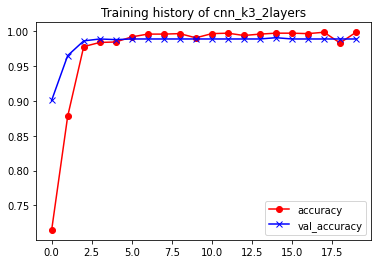

In [34]:
model_name = model_names[3]
print(model_name)

check_point = make_checkpointer(model_name)
model = create_CNN_model(layers=2, kernel_size=3)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics= metrics)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)

In [36]:
evaluate_model(model, model_name)

Test set 2 F1 score:
0.9908199505424835
Test set 3 F1 score:
0.997254182079883
Test set 4 F1 score:
0.9980058024540488
Test set 5 F1 score:
0.9968615292808549
Test set 1 F1 score:
0.999680747563294


2022-04-04 00:34:34.788604: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-04-04 00:34:35.033793: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


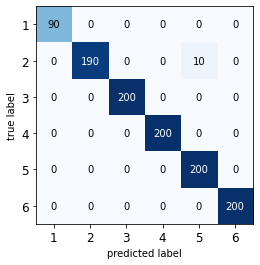

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

t = 0
predictions = model.predict(X_test[t])
predictions = np.argmax(predictions, axis = -1)
labels = Y_test[t]

cm  = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm,figsize=(4,4), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.yticks(range(NUM_CLASSES), [i+1 for i in range(NUM_CLASSES)], fontsize=12)
plt.show()